In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# get the data
features_df=pd.read_csv('data/features.csv')
store_df=pd.read_csv('data/stores.csv')
sales_df=pd.read_csv('data/train.csv')

# first look at how the data is stored

In [3]:
print(features_df.info(),store_df.info(),sales_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Typ

In [4]:
features_df["Date"] = pd.to_datetime(features_df["Date"])
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
#we cant test\train on data later than 2012-10-26 so for this excersize it is useless
last_Date = sales_df.Date.max()
features_df = features_df[features_df["Date"]<=last_Date]

In [5]:
features_df.MarkDown5.value_counts(dropna=False)
#seems like theres no 0's in MarkDowns so we wont lose any information turning Nan into 0's but is it the right choice 

NaN        4140
1064.56       2
2743.18       2
492.36        1
755.80        1
           ... 
3154.77       1
1941.32       1
2862.32       1
1610.18       1
858.33        1
Name: MarkDown5, Length: 2294, dtype: int64

In [6]:
features_df["isNAn"] = features_df["MarkDown4"].isna()
#we will take MarkDown4 as a sample since the Data in other MarkDowns is similiar on other MarkDown columns

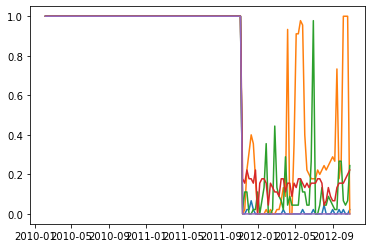

In [7]:
fig, ax = plt.subplots() 
for i in [1,2,3,4,5]:
    features_df["isNAn"] = features_df["MarkDown" + str(i)].isna()
    #fig, ax = plt.subplots()
    ax.plot(features_df.groupby("Date").isNAn.agg("mean"))

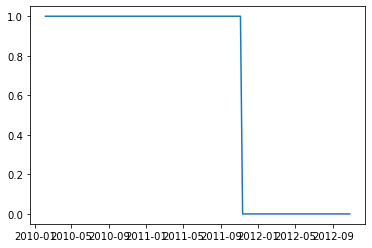

In [8]:
fig, ax = plt.subplots() 
ax.plot(features_df.groupby("Date").isNAn.agg("mean"))
#seems like they started tracking the markdowns only from a certain date thus 0 doesnt have a particular meaning 
#either take average markdown or not use markdowns(not ideal)
#if theres hope to get more markdown Data at the fututre to train on we would have used it but this time its better to use more data

In [9]:
#drop markdowns
markdowns = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",]
features_df = features_df.drop (columns = markdowns)

**after doing immediate changes we will merge our data into one table**

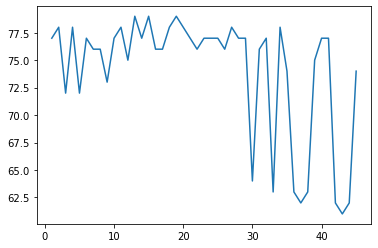

In [10]:
#first look at sales_df departments
fig, ax = plt.subplots() 
ax.plot(sales_df.groupby("Store").Dept.agg("nunique"))
#we can see not all stores have the same number or even the same departments
#we would want to predict the sales in each department

In [11]:
df = pd.merge(sales_df,features_df,how="outer",on=["Store","Date"])
df = pd.merge(df,store_df,how="outer",on=["Store"])
df=df.drop(columns=["isNAn"])

# first look at our data

In [12]:
df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,False,A,151315
5,1,6,2010-02-05,5749.03,False,42.31,2.572,211.096358,8.106,False,A,151315
6,1,7,2010-02-05,21084.08,False,42.31,2.572,211.096358,8.106,False,A,151315
7,1,8,2010-02-05,40129.01,False,42.31,2.572,211.096358,8.106,False,A,151315
8,1,9,2010-02-05,16930.99,False,42.31,2.572,211.096358,8.106,False,A,151315
9,1,10,2010-02-05,30721.50,False,42.31,2.572,211.096358,8.106,False,A,151315


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   IsHoliday_y   421570 non-null  bool          
 10  Type          421570 non-null  object        
 11  Size          421570 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 36.2+ MB


In [14]:
df = df.drop(columns = ["IsHoliday_y"])
df.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [15]:
df[df["Weekly_Sales"]<0].Weekly_Sales.describe()
#looks like the sales are not a typo mistake but actual losses

count    1285.000000
mean      -68.608218
std       231.664245
min     -4988.940000
25%       -41.000000
50%       -13.200000
75%        -4.940000
max        -0.020000
Name: Weekly_Sales, dtype: float64

In [16]:
multi_index_df=df.set_index(["Date","Store","Dept"]).sort_index()

In [17]:
multi_index_df.groupby(level=[1,2]).shift(1)
#not in final product, just an example of how to work with multi index
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [18]:
columns=['Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']
for column in columns:
    multi_index_df["Last_Week_"+column]=multi_index_df.groupby(level=[1,2])[column].shift(1)

In [19]:
 multi_index_df["Is_next_Week_Holiday"]=multi_index_df.groupby(level=[1,2])["IsHoliday"].shift(-1)

In [20]:
#doesnt work, sunk cost fallacy wouldnt get me
#our regular way is exposed to edge cases due to being by index but pandas refuses to be normal with time index and multi index  
# def rolling_time(ser: pd.Series):
#     ser=ser.reset_index().set_index("Date")
#     store=ser["Store"][0]
#     ser[store]=ser[store].rolling("21D").mean()
#     return ser
# multi_index_df.groupby(level=[1,2])["Weekly_Sales"].apply(lambda x :rolling_time(x))

In [21]:
columns=['Weekly_Sales', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']
for column in columns:
    multi_index_df["rolling_Mean_"+column]=multi_index_df.groupby(level=[1,2])["Last_Week_"+column].apply(lambda x :x.rolling(5).mean())

In [22]:
 multi_index_df.columns

Index(['Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Type', 'Size', 'Last_Week_Weekly_Sales',
       'Last_Week_IsHoliday', 'Last_Week_Temperature', 'Last_Week_Fuel_Price',
       'Last_Week_CPI', 'Last_Week_Unemployment', 'Is_next_Week_Holiday',
       'rolling_Mean_Weekly_Sales', 'rolling_Mean_Temperature',
       'rolling_Mean_Fuel_Price', 'rolling_Mean_CPI',
       'rolling_Mean_Unemployment'],
      dtype='object')

In [53]:
#start visualization 
#
target_column="Weekly_Sales"
countable_columns= [
    "IsHoliday","Type","Is_next_Week_Holiday","Last_Week_IsHoliday"
]
uncountable_columns= [
    'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment',  'Size', 'Last_Week_Weekly_Sales',
        'Last_Week_Temperature', 'Last_Week_Fuel_Price',
       'Last_Week_CPI', 'Last_Week_Unemployment', 
       'rolling_Mean_Weekly_Sales', 
       'rolling_Mean_Temperature', 'rolling_Mean_Fuel_Price',
       'rolling_Mean_CPI', 'rolling_Mean_Unemployment'
]

legend_colors = ['tab:blue', 'tab:orange']

# Config columns names
target_column_label = "Weekly_Sales"

In [24]:
def disply_atter_per_column(inedexs: list, values: list, columns_label: list):
    global legend_colors, target_column, target_column_label
    
    # Main elements    
    fig = plt.figure(figsize = [16, 8])
        
    for i in range(len(values)):        
        value = values[i]
        if value is not None:
            index = indexs[i]
            label = columns_label[i]
            
            # Graf
            ax_graf =  fig.add_subplot(1, len(values), i+1)
            
            plt.sca(ax_graf)
            plt.plot(index, value)
            plt.xlabel(label)
            plt.ylabel(target_column_label)
            
    plt.show()

In [25]:
def disply_multi_bars(inedexs: list, values: list, indexs_label, values_label, elements_in_line: int):
    global legend_colors
    
    values += np.full(elements_in_line-len(values)%elements_in_line, None).tolist()
    inedexs += np.full(elements_in_line-len(values)%elements_in_line, None).tolist()
    
    h = int(len(values) / elements_in_line)
    
    # Main elements 
    fig = plt.figure(figsize = [16, h * 8])
    
    gs = fig.add_gridspec(h, elements_in_line)
    
    line = 0
    while len(values) > 0:
        now_values = values[:elements_in_line]
        now_inedexs = inedexs[:elements_in_line]
                
        for i in range(elements_in_line):        
            value = now_values[i]
            if value is not None:
                index = now_inedexs[i]
                value = now_values[i]
            
                index_label = indexs_label
                value_label = values_label
                if type(indexs_label) == list:
                    index_label = indexs_label[i]
            
                if type(values_label) == list:
                    value_label = values_label[i]
            
                # Graf
                ax_graf = fig.add_subplot(gs[line, i])
        
                plt.sca(ax_graf)
                plt.bar(index, value)
                plt.xlabel(index_label)
                plt.ylabel(value_label)
                
        values = values[elements_in_line:]
        inedexs = inedexs[elements_in_line:]
        
        if type(indexs_label) == list:
            indexs_label = indexs_label[elements_in_line:]
            
        if type(values_label) == list:
            values_label = values_label[elements_in_line:]
        
        line += 1
    
    plt.show()

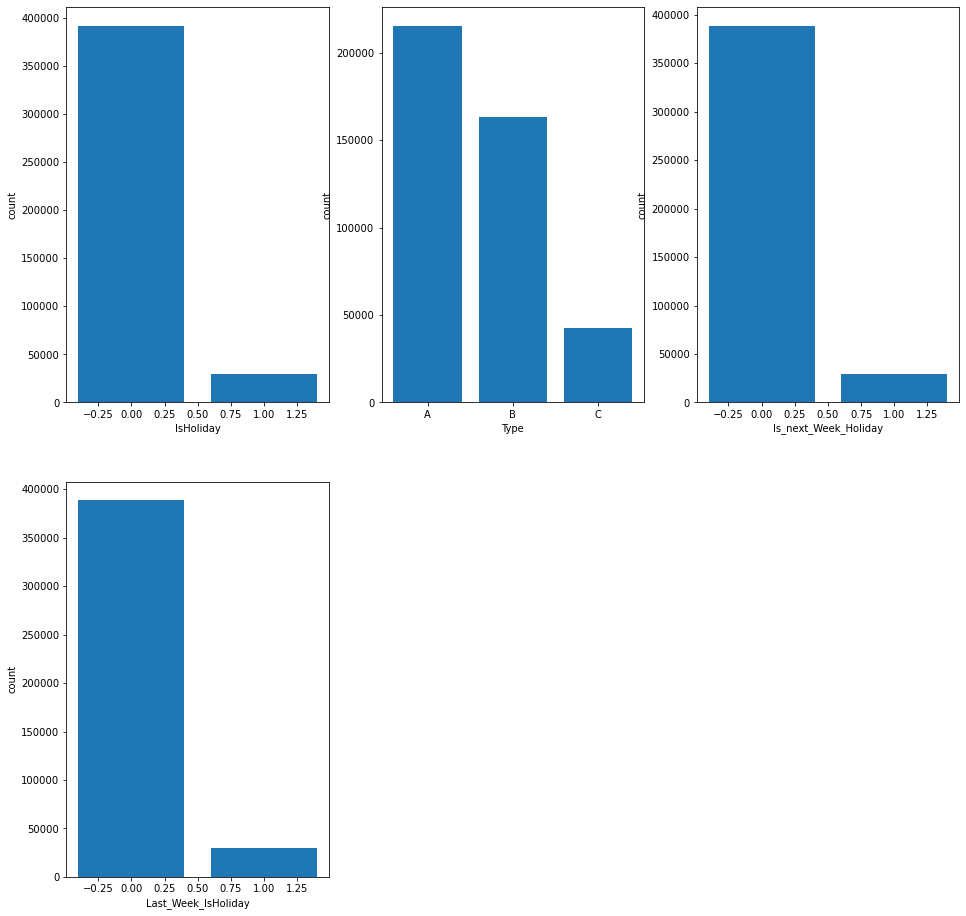

In [28]:
printed_columns = countable_columns  
elements_in_line = 3
indexs = []
values = []
for column in printed_columns:
    if column is not None:
        count_df = multi_index_df[[target_column, column]].groupby([column]).count()

        indexs += [count_df.index]
        values += [count_df[target_column].values.tolist()]            

disply_multi_bars(indexs, values, printed_columns, 'count', elements_in_line)

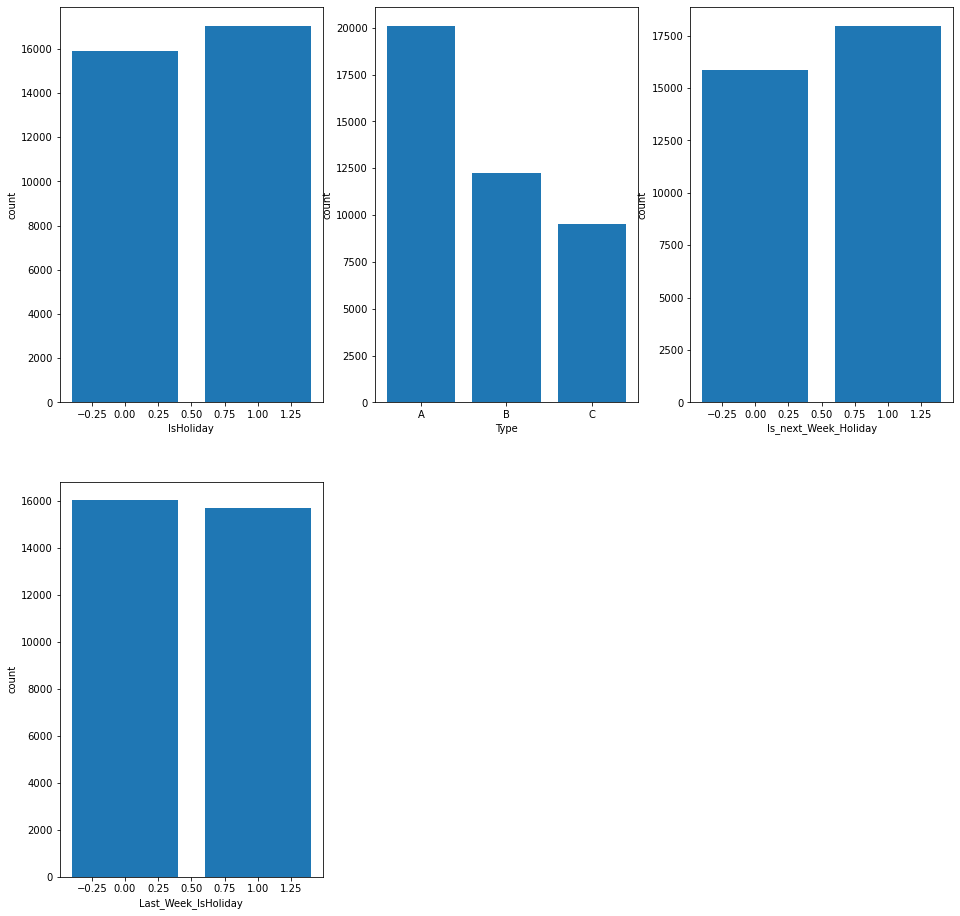

In [29]:
printed_columns = countable_columns  
elements_in_line = 3
indexs = []
values = []
for column in printed_columns:
    if column is not None:
        mean_df = multi_index_df[[target_column, column]].groupby([column]).mean()

        indexs += [mean_df.index]
        values += [mean_df[target_column].values.tolist()]            

disply_multi_bars(indexs, values, printed_columns, 'count', elements_in_line)

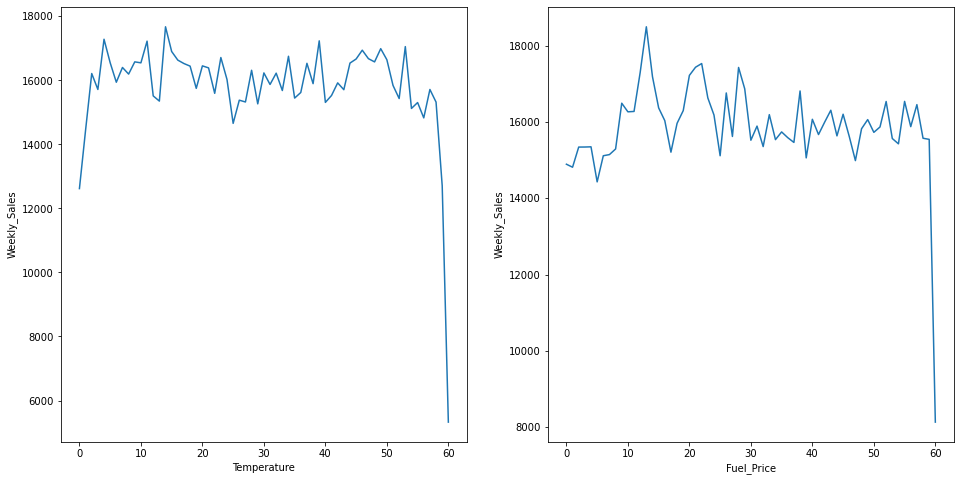

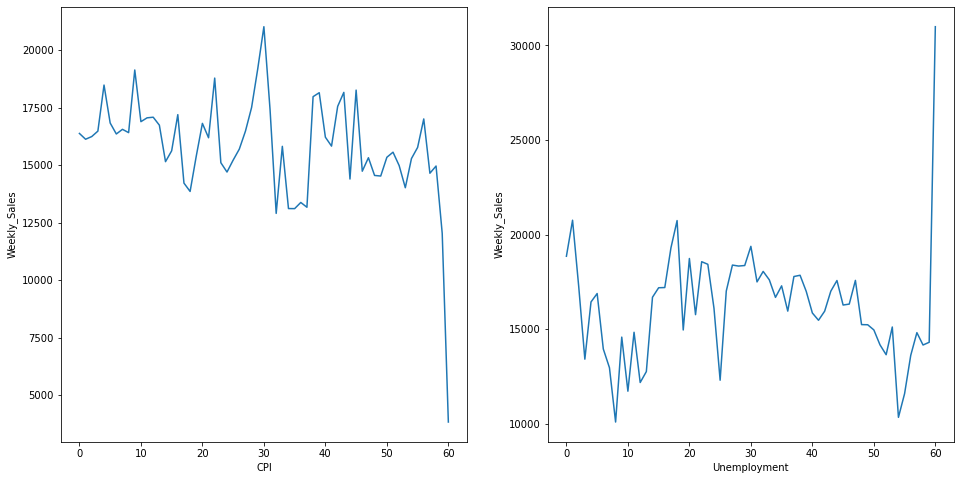

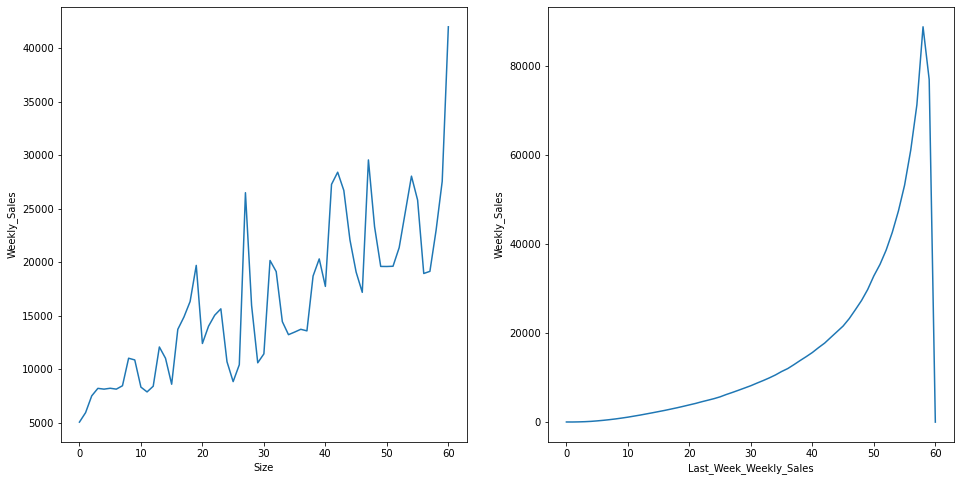

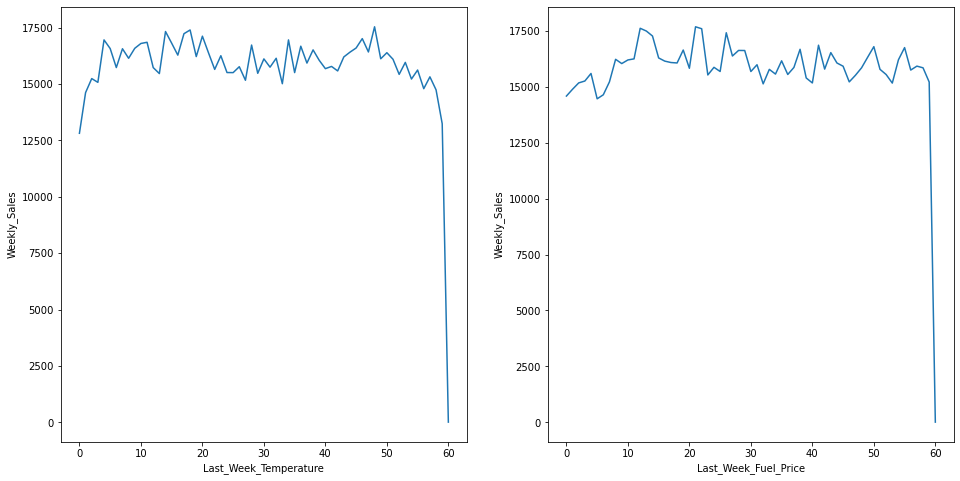

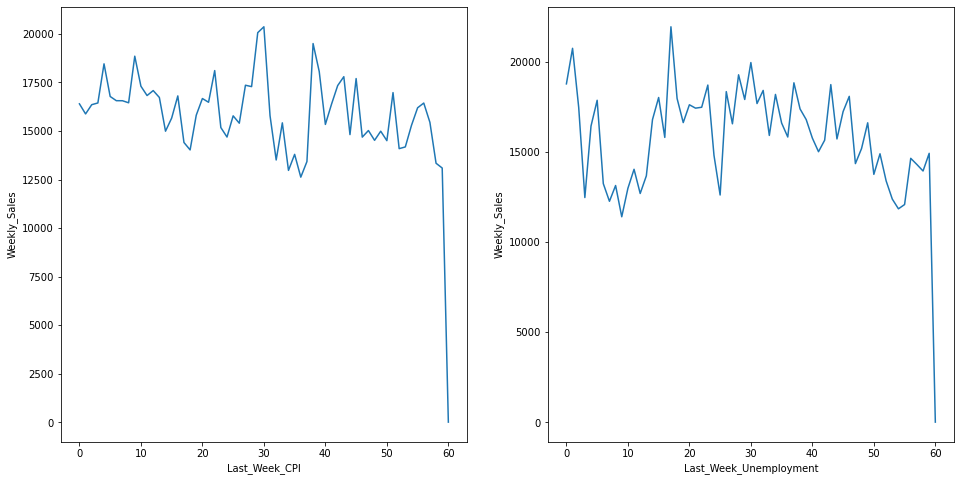

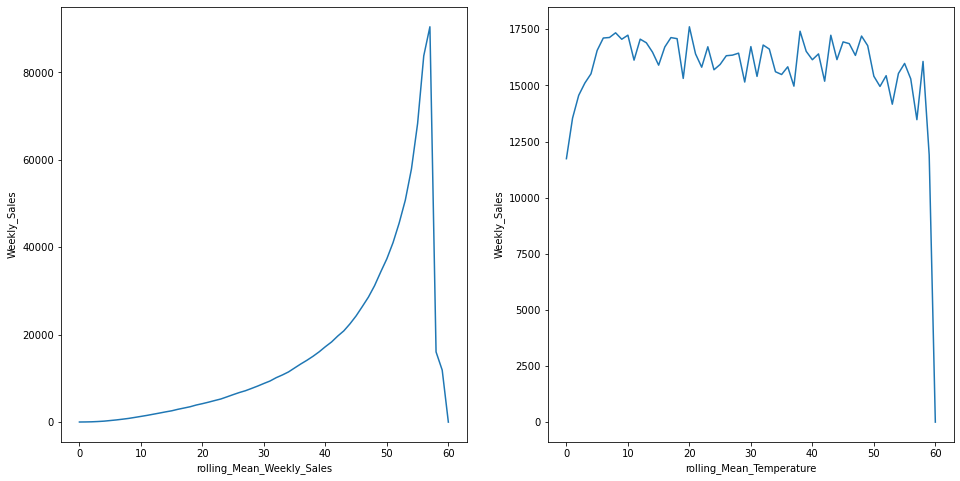

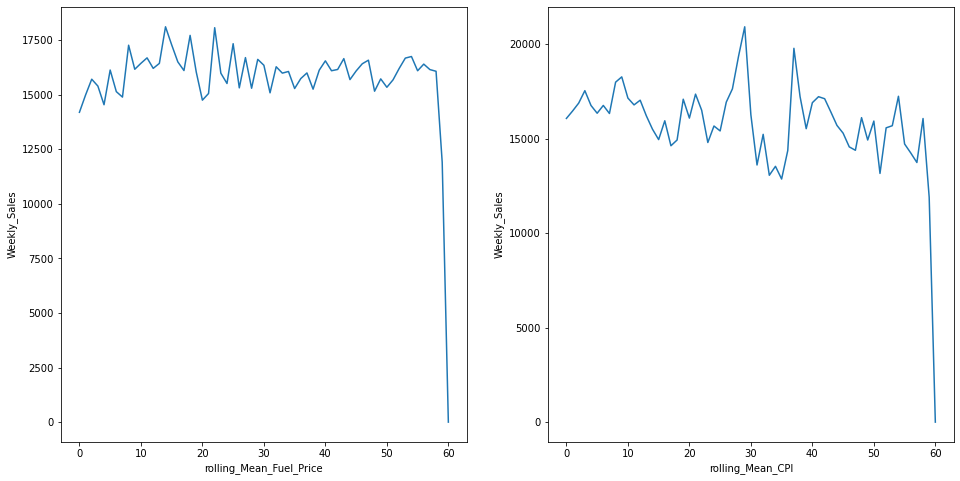

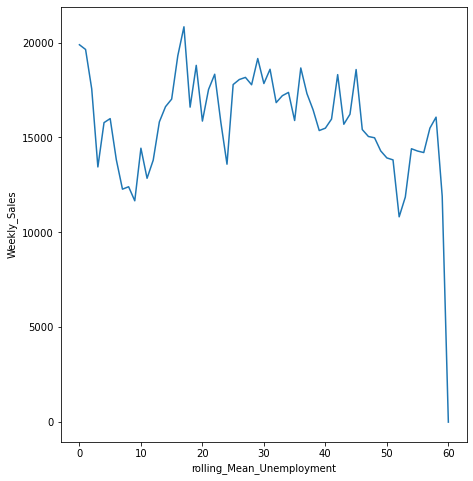

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [50]:
sections=60
atter_name = 'mean'
elements_in_line = 2
printed_columns = uncountable_columns

printed_columns += np.full(elements_in_line-len(printed_columns)%elements_in_line, None).tolist()
while len(printed_columns) > 0:
    now_columns = printed_columns[:elements_in_line]
    indexs = []
    values = []
    for column in now_columns:
        if column is None:
            indexs += [None]
            values += [None]
        else:
            new_df = multi_index_df[[target_column, column]].sort_values(column)
            length = len(new_df)
            new_df["Sections"] = df.index//(length//sections)
            atter_df = new_df[[target_column, "Sections"]].groupby(["Sections"])
            atter_df = getattr(atter_df, atter_name)()

            indexs += [atter_df.index]
            values += [atter_df[target_column].values]            

    disply_atter_per_column(indexs, values, printed_columns[:elements_in_line])
    printed_columns = printed_columns[elements_in_line:]

In [34]:
#seems like the main thing that we can get information from is recent sales and size in the countable columns
#to better make sure we need to see 1)the direct effect(not by proportion of data) and 2) compare it to the average weekly sales of the dept

In [54]:
columns=[
    'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment',
        'Last_Week_Temperature', 'Last_Week_Fuel_Price',
       'Last_Week_CPI', 'Last_Week_Unemployment', 
       'rolling_Mean_Weekly_Sales', 
       'rolling_Mean_Temperature', 'rolling_Mean_Fuel_Price',
       'rolling_Mean_CPI', 'rolling_Mean_Unemployment'
]


In [55]:
multi_index_df["Dept_Mean"]= multi_index_df.groupby(level=[1,2])["Weekly_Sales"].transform("mean")

False
False


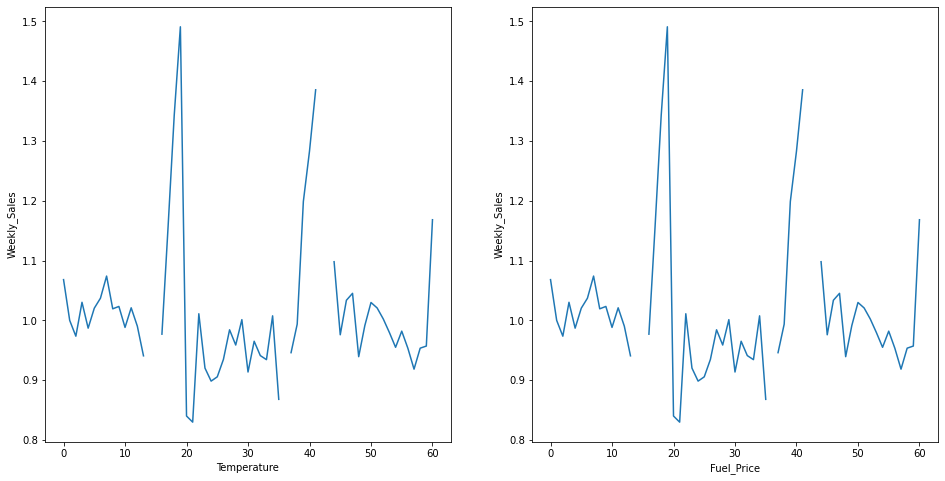

False
False


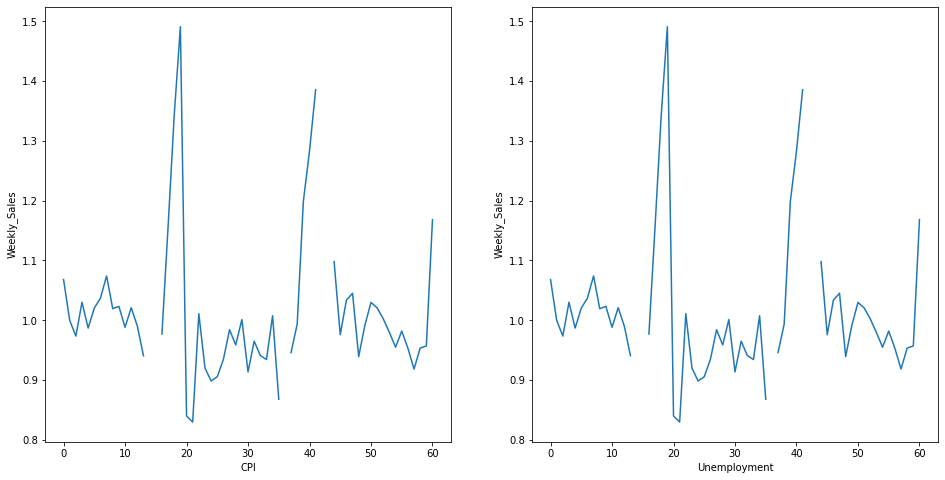

False
False


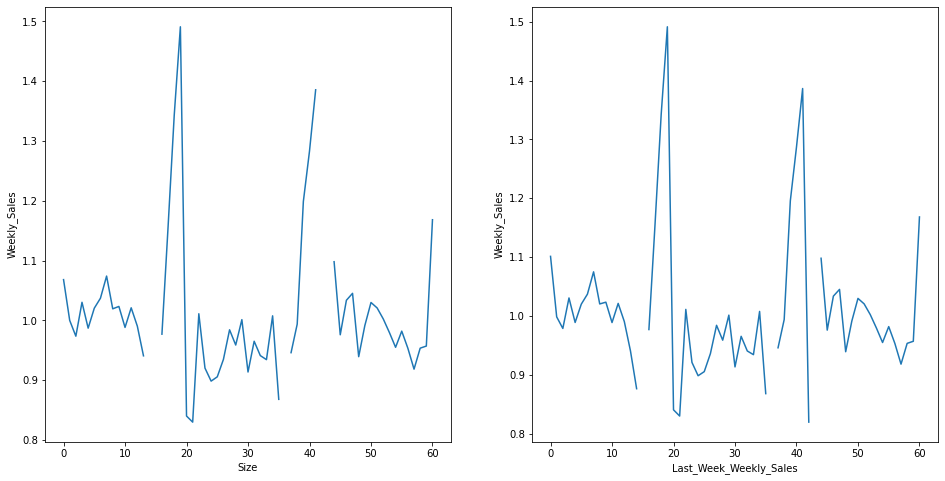

False
False


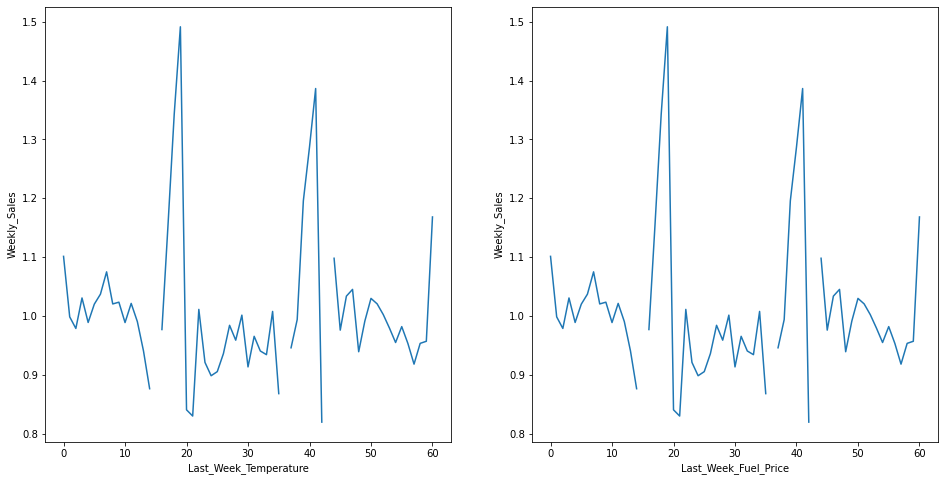

False
False


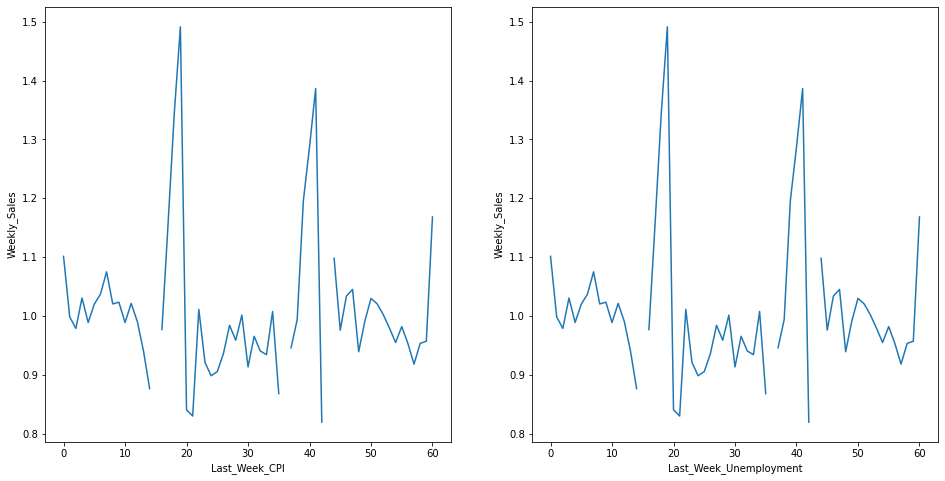

False
False


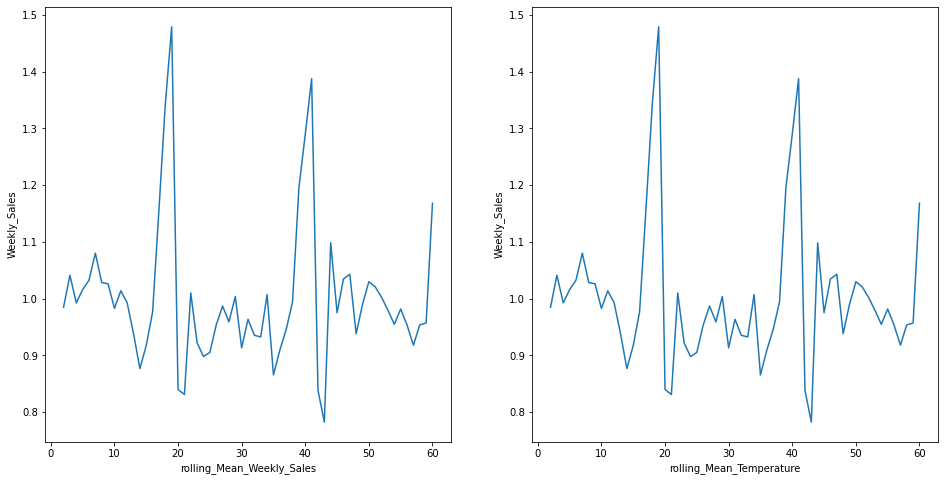

False
False


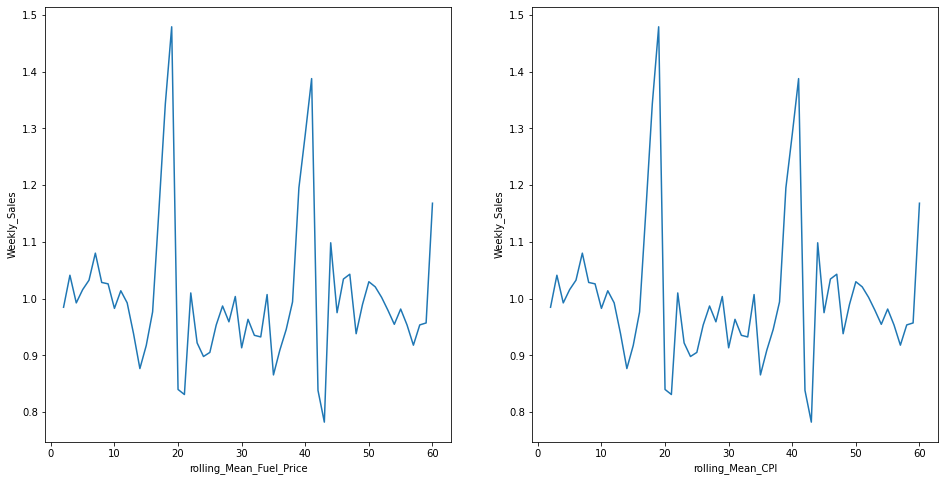

False


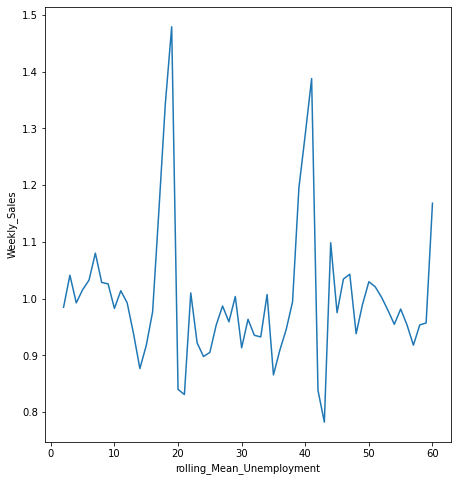

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [72]:
#
sections=60
atter_name = 'mean'
elements_in_line = 2
printed_columns = uncountable_columns

printed_columns += np.full(elements_in_line-len(printed_columns)%elements_in_line, None).tolist()
while len(printed_columns) > 0:
    now_columns = printed_columns[:elements_in_line]
    indexs = []
    values = []
    for column in now_columns:
        if column is None:
            indexs += [None]
            values += [None]
        else:
            new_df = multi_index_df[[target_column, column,"Dept_Mean"]].copy().reset_index()
            new_df["M_adjusted"] = new_df[target_column]/new_df["Dept_Mean"]
            new_df.dropna(inplace = True)
            print(new_df.isnull().values.any())
            new_df = new_df.sort_values(column)
            new_df["Sections"] = new_df.index//(length//sections)
            atter_df = new_df[["Sections", "M_adjusted"]].groupby(["Sections"])
           
            atter_df = atter_df.mean()
            indexs += [atter_df.index]
            values += [atter_df["M_adjusted"].values]            

    disply_atter_per_column(indexs, values, printed_columns[:elements_in_line])
    printed_columns = printed_columns[elements_in_line:]